# SPRINT 3

With sprint 2 we were able to develop a very accurate binary  classifier. The aim of sprint 3 is the following: develop a multiclass classifier capable of identifying the kind of cyberattack taking place.

We have 5 types of Recon Attacks in our dataset.

- *Ping Sweep Attack*: This method involves sending ICMP Echo Request messages to multiple IP addresses within a network to identify which devices are active based on the ICMP Echo Replies received.

- *OS Scan Attack*: Also known as operating system fingerprinting, this attack aims to determine the type and version of operating systems running on networked devices through packet response analysis or observing the behavior of open ports and services.

- *Vulnerability Scan*: This involves the use of automated tools to detect security weaknesses in computer systems or networks, identifying vulnerabilities that could be exploited by attackers.

- *Port Scan Attack*: By sending packets to various ports on a targeted host and analyzing the responses, attackers can identify which ports are open, closed, or filtered, revealing potential entry points into the system.

- *Host Discovery*: This is the process of identifying active devices on a network by using different techniques to enumerate the IP addresses of connected devices, serving as a foundational step in many cyber attacks.


The notebook is divided in three sections.

- **Load the data and process it**: same steps as before with one change, our y column. It will keep all of the cyberattack types without aggregation into binary classes.
- **From binary to Multiclass**: In this section I will experiment many different options for our multiclass classifier. I will investigate how accurate it can be by employing a two staged model and try two different ways to do it.

## Load data and process it

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, precision_score, ConfusionMatrixDisplay, accuracy_score, roc_curve, roc_auc_score
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.ensemble import AdaBoostClassifier



### Extracting the relevant data from csv files


Now, we know from previous exploration that we have 34 labels. For EDA purposes we should remap them in 5 kinds:

- Benign Traffic
- DDoS attacks
- DoS attacks
- Mirai attacks
- Spoofing attacks
- Web attacks
- Brute Force attacks
- Recon attacks

The following table breaks down the categories:

| Attack Category    | Attack Objective                                  | Entry Points                | Expected Network Traffic Change |
|--------------------|---------------------------------------------------|-----------------------------|---------------------------------|
| Benign Traffic     | Normal network operations                         | Various                     | No significant change          |
| DDoS Attacks       | Disrupt service by overwhelming resources         | Network interfaces          | Significant increase           |
| DoS Attacks        | Disrupt service to a server or network            | Network interfaces          | Sudden spike or drop           |
| Mirai Attacks      | Exploit IoT devices for large-scale attacks       | IoT devices                 | Varied, often increased        |
| Spoofing Attacks   | Impersonate devices or users                      | Network interfaces, devices | Varied, potential increase     |
| Web Attacks        | Exploit web services vulnerabilities              | Web servers, applications   | Varied, often targeted         |
| Brute Force Attacks| Crack passwords through trial and error          | Authentication systems      | Varied, often increased        |
| Recon Attacks      | Gather information about network and vulnerabilities | Network scanning, probing | Minor, but patterned increase  |


We know from the litterature on the dataset that previous modelling attempts were very good at detecting DDoS and DoS attacks.

This is why we focus on Recon attacks.

To do so we have to extract relevant data from the 126 .csv files and create a single data frame.

Let's first take a sample from these:

In [3]:
# Creating list of csv files 
directory = r"C:\Users\dfuma\Documents\cybersec_cap\data\wataiData\csv\CICIoT2023"
csv_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.csv')]

# Taking one sample
sample_df = pd.read_csv(r"C:\Users\dfuma\Documents\cybersec_cap\data\wataiData\csv\CICIoT2023\part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv")
sample_df.columns

Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
       'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'label'],
      dtype='object')

Now we have to make sure the data types will stay the same while we append each chunk to the combined data frame.

In [4]:
# Create dictionary with column and data type
d_types = {k: v.name for k, v in zip(sample_df.columns,sample_df.dtypes)}

d_types

{'flow_duration': 'float64',
 'Header_Length': 'float64',
 'Protocol Type': 'float64',
 'Duration': 'float64',
 'Rate': 'float64',
 'Srate': 'float64',
 'Drate': 'float64',
 'fin_flag_number': 'float64',
 'syn_flag_number': 'float64',
 'rst_flag_number': 'float64',
 'psh_flag_number': 'float64',
 'ack_flag_number': 'float64',
 'ece_flag_number': 'float64',
 'cwr_flag_number': 'float64',
 'ack_count': 'float64',
 'syn_count': 'float64',
 'fin_count': 'float64',
 'urg_count': 'float64',
 'rst_count': 'float64',
 'HTTP': 'float64',
 'HTTPS': 'float64',
 'DNS': 'float64',
 'Telnet': 'float64',
 'SMTP': 'float64',
 'SSH': 'float64',
 'IRC': 'float64',
 'TCP': 'float64',
 'UDP': 'float64',
 'DHCP': 'float64',
 'ARP': 'float64',
 'ICMP': 'float64',
 'IPv': 'float64',
 'LLC': 'float64',
 'Tot sum': 'float64',
 'Min': 'float64',
 'Max': 'float64',
 'AVG': 'float64',
 'Std': 'float64',
 'Tot size': 'float64',
 'IAT': 'float64',
 'Number': 'float64',
 'Magnitue': 'float64',
 'Radius': 'float64',


Now let's use this data type read each csv. Subsequently we will filter on the labels that we need: those whith benign traffic and those with the 5 kinds of recon attacks.

In [5]:
# Initialize empty df
combined_df = pd.DataFrame()


# List the labels that we need from each csv file
labels_select = ['Recon-PingSweep', 'Recon-OSScan', 'Recon-PortScan', 'VulnerabilityScan', 'Recon-HostDiscovery', 'BenignTraffic']

# Loop over the list of csv file
for file_path in csv_files:
    df = pd.read_csv(file_path, dtype=d_types, low_memory=False) # read the data with d_types

    # Filter based on the selected labels
    filtered_df = df[df['label'].isin(labels_select)]

    # append to combined_df
    combined_df = pd.concat([combined_df, filtered_df], ignore_index=True)



In [6]:
# Check the result
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1452760 entries, 0 to 1452759
Data columns (total 47 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   flow_duration    1452760 non-null  float64
 1   Header_Length    1452760 non-null  float64
 2   Protocol Type    1452760 non-null  float64
 3   Duration         1452760 non-null  float64
 4   Rate             1452760 non-null  float64
 5   Srate            1452760 non-null  float64
 6   Drate            1452760 non-null  float64
 7   fin_flag_number  1452760 non-null  float64
 8   syn_flag_number  1452760 non-null  float64
 9   rst_flag_number  1452760 non-null  float64
 10  psh_flag_number  1452760 non-null  float64
 11  ack_flag_number  1452760 non-null  float64
 12  ece_flag_number  1452760 non-null  float64
 13  cwr_flag_number  1452760 non-null  float64
 14  ack_count        1452760 non-null  float64
 15  syn_count        1452760 non-null  float64
 16  fin_count        1

In [7]:
# Check shape
combined_df.shape[0]

1452760

In [8]:
# Check NAs, we expect 0
combined_df.isna().sum()

flow_duration      0
Header_Length      0
Protocol Type      0
Duration           0
Rate               0
Srate              0
Drate              0
fin_flag_number    0
syn_flag_number    0
rst_flag_number    0
psh_flag_number    0
ack_flag_number    0
ece_flag_number    0
cwr_flag_number    0
ack_count          0
syn_count          0
fin_count          0
urg_count          0
rst_count          0
HTTP               0
HTTPS              0
DNS                0
Telnet             0
SMTP               0
SSH                0
IRC                0
TCP                0
UDP                0
DHCP               0
ARP                0
ICMP               0
IPv                0
LLC                0
Tot sum            0
Min                0
Max                0
AVG                0
Std                0
Tot size           0
IAT                0
Number             0
Magnitue           0
Radius             0
Covariance         0
Variance           0
Weight             0
label              0
dtype: int64

In [9]:
# Check for duplicates (we expect very few)
combined_df.duplicated().sum()

5

In [10]:
# Remove duplicates: df
df = combined_df.drop_duplicates()

In [13]:
# Clear memory
del combined_df
del sample_df

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1452755 entries, 0 to 1452759
Data columns (total 47 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   flow_duration    1452755 non-null  float64
 1   Header_Length    1452755 non-null  float64
 2   Protocol Type    1452755 non-null  float64
 3   Duration         1452755 non-null  float64
 4   Rate             1452755 non-null  float64
 5   Srate            1452755 non-null  float64
 6   Drate            1452755 non-null  float64
 7   fin_flag_number  1452755 non-null  float64
 8   syn_flag_number  1452755 non-null  float64
 9   rst_flag_number  1452755 non-null  float64
 10  psh_flag_number  1452755 non-null  float64
 11  ack_flag_number  1452755 non-null  float64
 12  ece_flag_number  1452755 non-null  float64
 13  cwr_flag_number  1452755 non-null  float64
 14  ack_count        1452755 non-null  float64
 15  syn_count        1452755 non-null  float64
 16  fin_count        145275

Now let's change the data types for better efficiency

In [15]:
dtypes = {
        'flow_duration': np.float32,
        'Header_Length': np.uint32,
        'Protocol Type': str,
        'Duration': np.float32,
        'Rate': np.uint32,
        'Srate': np.uint32,
        'Drate': np.float32,
        'fin_flag_number': np.bool_,
        'syn_flag_number': np.bool_,
        'rst_flag_number': np.bool_,
        'psh_flag_number': np.bool_,
        'ack_flag_number': np.bool_,
        'ece_flag_number': np.bool_,
        'cwr_flag_number': np.bool_,
        'ack_count': np.float16,
        'syn_count': np.float16,
        'fin_count': np.uint16,
        'urg_count': np.uint16, 
        'rst_count': np.uint16, 
        'HTTP': np.bool_, 
        'HTTPS': np.bool_, 
        'DNS': np.bool_, 
        'Telnet': np.bool_,
        'SMTP': np.bool_, 
        'SSH': np.bool_, 
        'IRC': np.bool_, 
        'TCP': np.bool_, 
        'UDP': np.bool_, 
        'DHCP': np.bool_, 
        'ARP': np.bool_, 
        'ICMP': np.bool_, 
        'IPv': np.bool_, 
        'LLC': np.bool_,
        'Tot sum': np.float32, 
        'Min': np.float32, 
        'Max': np.float32, 
        'AVG': np.float32, 
        'Std': np.float32, 
        'Tot size': np.float32, 
        'IAT': np.float32, 
        'Number': np.float32,
        'Magnitue': np.float32, 
        'Radius': np.float32, 
        'Covariance': np.float32, 
        'Variance': np.float32, 
        'Weight': np.float32, 
        'label': str
    }

# Define function to change data type and adjust formatting

def convert_dtype(df):
    # Adjust data type
    for col,typ in dtypes.items():
        df[col] = df[col].astype(typ)   
    
    # Format column names to lowercase snake
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    # Fix spelling error in original dataset
    df['magnitude'] = df['magnitue']
    return df.drop(['magnitue'], axis=1)


# call the function
convert_dtype(df)

,flow_duration,header_length,protocol_type,duration,rate,srate,drate,fin_flag_number,syn_flag_number,rst_flag_number,...,std,tot_size,iat,number,radius,covariance,variance,weight,label,magnitude
0,37.887028,1687747,9.3,63.500000,34,34,0.0,False,False,False,...,332.122437,817.500000,5.235219e-03,5.5,469.692078,2.092362e+05,0.9,38.500000,BenignTraffic,24.333355
1,48.272385,128041,10.4,97.800003,39966,39966,0.0,False,False,False,...,694.907043,636.400024,1.665200e+08,13.5,983.968323,4.842123e+05,1.0,244.600006,BenignTraffic,36.393288
2,48.095661,101026,8.8,137.699997,13,13,0.0,False,False,False,...,1302.117188,919.299988,2.724581e-02,5.5,1841.471802,2.063959e+06,0.9,38.500000,BenignTraffic,47.214172
3,46.342407,1301464,4.8,168.300003,34,34,0.0,False,False,False,...,0.428562,64.800003,3.804951e-02,5.5,0.606078,9.315556e-01,0.2,38.500000,BenignTraffic,11.472816
4,88.807747,5290348,7.1,63.599998,61,61,0.0,False,False,False,...,101.938538,1227.300049,1.833391e-03,5.5,144.162857,5.276998e+04,0.2,38.500000,BenignTraffic,54.184532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452755,0.732928,2250732,6.0,93.500000,2782,2782,0.0,False,False,False,...,836.076416,917.599976,8.809566e-05,5.5,1182.390625,8.859554e+05,0.8,38.500000,BenignTraffic,38.208549
1452756,13.401717,11497,6.0,59.200001,11,11,0.0,False,False,False,...,64.519730,108.199997,9.288311e-03,5.5,91.244675,4.696484e+03,0.9,38.500000,BenignTraffic,14.697835
1452757,9.528511,116067,12.6,82.699997,17,17,0.0,False,False,False,...,187.924698,337.500000,1.846900e-02,5.5,265.765656,6.190794e+04,0.9,38.500000,BenignTraffic,19.810381
1452758,16.250675,85094,8.8,103.400002,15,15,0.0,False,False,False,...,857.873474,105.800003,1.665168e+08,13.5,1215.209839,7.409860e+05,1.0,244.600006,BenignTraffic,34.988182


In order to perform EDA we need change protocol types in a format that is human readable. Right now they are a float indicating the protocol type. We will turn that into an integer and apply a mapping with the description of the protocol type using IANA (Internet Assigned Numbers Authority) protocol numbers.

In [17]:
# Map IANA Protocol numbers to strings (leave user option to 1-hot or numerically encode)
iana_map = { 
    "0": "HOPOPT", "1": "ICMP", "2": "IGMP", "3": "GGP", "4": "IPv4", "5": "ST", 
    "6": "TCP", "7": "CBT", "8": "EGP", "9": "IGP", "10": "BBN-RCC-MON", "11": "NVP-II", 
    "12": "PUP", "13": "ARGUS (deprecated)", "14": "EMCON", "15": "XNET", "16": "CHAOS", 
    "17": "UDP", "18": "MUX", "19": "DCN-MEAS", "20": "HMP", "21": "PRM", "22": "XNS-IDP", 
    "23": "TRUNK-1", "24": "TRUNK-2", "25": "LEAF-1", "26": "LEAF-2", "27": "RDP", 
    "28": "IRTP", "29": "ISO-TP4", "30": "NETBLT", "31": "MFE-NSP", "32": "MERIT-INP", 
    "33": "DCCP", "34": "3PC", "35": "IDPR", "36": "XTP", "37": "DDP", "38": "IDPR-CMTP", 
    "39": "TP++", "40": "IL", "41": "IPv6", "42": "SDRP", "43": "IPv6-Route", 
    "44": "IPv6-Frag", "45": "IDRP", "46": "RSVP", "47": "GRE", "48": "DSR", "49": "BNA", 
    "50": "ESP", "51": "AH", "52": "I-NLSP", "53": "SWIPE (deprecated)", "54": "NARP", 
    "55": "MOBILE", "56": "TLSP", "57": "SKIP", "58": "IPv6-ICMP", "59": "IPv6-NoNxt", 
    "60": "IPv6-Opts", "62": "CFTP", "64": "SAT-EXPAK", "65": "KRYPTOLAN", "66": "RVD", 
    "67": "IPPC", "69": "SAT-MON", "70": "VISA", "71": "IPCV", "72": "CPNX", "73": "CPHB", 
    "74": "WSN", "75": "PVP", "76": "BR-SAT-MON", "77": "SUN-ND", "78": "WB-MON", 
    "79": "WB-EXPAK", "80": "ISO-IP", "81": "VMTP", "82": "SECURE-VMTP", "83": "VINES", 
    "84": "IPTM", "85": "NSFNET-IGP", "86": "DGP", "87": "TCF", "88": "EIGRP", 
    "89": "OSPFIGP", "90": "Sprite-RPC", "91": "LARP", "92": "MTP", "93": "AX.25", 
    "94": "IPIP", "95": "MICP (deprecated)","96": "SCC-SP", "97": "ETHERIP", "98": "ENCAP", 
    "100": "GMTP", "101": "IFMP", "102": "PNNI", "103": "PIM", "104": "ARIS", "105": "SCPS", 
    "106": "QNX", "107": "A/N", "108": "IPComp", "109": "SNP", "110": "Compaq-Peer", 
    "111": "IPX-in-IP", "112": "VRRP", "113": "PGM", "114": "", "115": "L2TP", "116": "DDX",  
    "117": "IATP", "118": "STP", "119": "SRP", "120": "UTI", "121": "SMP", 
    "122": "SM (deprecated)", "123": "PTP","124": "ISIS over IPv4", "125": "FIRE", 
    "126": "CRTP", "127": "CRUDP", "128": "SSCOPMCE", "129": "IPLT", "130": "SPS", 
    "131": "PIPE", "132": "SCTP",  "133": "FC", "134": "RSVP-E2E-IGNORE", 
    "135": "Mobility Header", "136": "UDPLite", "137": "MPLS-in-IP", "138": "manet", 
    "139": "HIP", "140": "Shim6", "141": "WESP", "142": "ROHC", "143": "Ethernet", 
    "144": "AGGFRAG", "145": "NSH"
}

# transform the column protocol type

df['protocol_type'] = df['protocol_type'].apply(lambda x: iana_map[str(int(float(x)))])

set(df['protocol_type'])

{'ARGUS (deprecated)',
 'BBN-RCC-MON',
 'CBT',
 'CHAOS',
 'EGP',
 'EMCON',
 'GGP',
 'HOPOPT',
 'ICMP',
 'IGMP',
 'IGP',
 'IPv4',
 'NVP-II',
 'PUP',
 'ST',
 'TCP',
 'UDP',
 'XNET'}

In [18]:
df = pd.get_dummies(df, columns=['protocol_type'])

In [20]:
y = df['label']

In [22]:
# select numerical columns

df_numerical = df.select_dtypes(include=['bool','uint16','uint32','int64','float16','float32'])


### Final Checks


In [23]:
df_numerical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1452755 entries, 0 to 1452759
Data columns (total 64 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   flow_duration                     1452755 non-null  float32
 1   header_length                     1452755 non-null  uint32 
 2   duration                          1452755 non-null  float32
 3   rate                              1452755 non-null  uint32 
 4   srate                             1452755 non-null  uint32 
 5   drate                             1452755 non-null  float32
 6   fin_flag_number                   1452755 non-null  bool   
 7   syn_flag_number                   1452755 non-null  bool   
 8   rst_flag_number                   1452755 non-null  bool   
 9   psh_flag_number                   1452755 non-null  bool   
 10  ack_flag_number                   1452755 non-null  bool   
 11  ece_flag_number                   1452755 

We need the full memory at work! let's delete the memory

In [24]:

#df.to_csv('cybersec_reworked.csv', index=False)
del df

Check again d_types

In [25]:
d_types = {k: v.name for k, v in zip(df_numerical.columns,df_numerical.dtypes)}

d_types

{'flow_duration': 'float32',
 'header_length': 'uint32',
 'duration': 'float32',
 'rate': 'uint32',
 'srate': 'uint32',
 'drate': 'float32',
 'fin_flag_number': 'bool',
 'syn_flag_number': 'bool',
 'rst_flag_number': 'bool',
 'psh_flag_number': 'bool',
 'ack_flag_number': 'bool',
 'ece_flag_number': 'bool',
 'cwr_flag_number': 'bool',
 'ack_count': 'float16',
 'syn_count': 'float16',
 'fin_count': 'uint16',
 'urg_count': 'uint16',
 'rst_count': 'uint16',
 'http': 'bool',
 'https': 'bool',
 'dns': 'bool',
 'telnet': 'bool',
 'smtp': 'bool',
 'ssh': 'bool',
 'irc': 'bool',
 'tcp': 'bool',
 'udp': 'bool',
 'dhcp': 'bool',
 'arp': 'bool',
 'icmp': 'bool',
 'ipv': 'bool',
 'llc': 'bool',
 'tot_sum': 'float32',
 'min': 'float32',
 'max': 'float32',
 'avg': 'float32',
 'std': 'float32',
 'tot_size': 'float32',
 'iat': 'float32',
 'number': 'float32',
 'magnitue': 'float32',
 'radius': 'float32',
 'covariance': 'float32',
 'variance': 'float32',
 'weight': 'float32',
 'magnitude': 'float32',
 

Ok now we can use df_numerical and save it with integers vs boolean to ensure data type consistency across platforms (say on google colab)

In [26]:
# Convert boolean columns to integers
bool_cols = df_numerical.select_dtypes(include=['bool']).columns
df_numerical[bool_cols] = df_numerical[bool_cols].astype(int) # CONVERTING TO INTEGERS IN ORDER TO AVOID CORRUPTION

# Save to CSV
#df_numerical.to_csv('df_numerical_modified.csv', index=False)

# THIS WAS SENT TO GOOGLE COLAB

In [27]:
df_numerical.shape

(1452755, 64)

In [28]:
y.shape

(1452755,)

In [29]:
X = df_numerical

In [30]:
y.value_counts()

label
BenignTraffic          1098195
Recon-HostDiscovery     134377
Recon-OSScan             98259
Recon-PortScan           82280
VulnerabilityScan        37382
Recon-PingSweep           2262
Name: count, dtype: int64

There are simply too few records for Recon-Pingsweep. We will need to delete them.

In [31]:


ping_sweep_label = 'Recon-PingSweep' 
mask = y != ping_sweep_label

# Apply the mask to X and y to filter out 'ping-sweep' instances
X_drop = X[mask.values.ravel()]
y_drop = y[mask.values.ravel()]

## From Binary to Multiclass

We were successful in predicting if a Cyberattack was really going on. Our previous work resulted in a very accurate adaboost.

Still in an experimental fashion I will run another experiment:

**Can we use this prediction as a "feature" to feed multiclass models?**

In order to do so, let's first load our results from adaboost and create a new feature: 'adaboost_binary_pred'

In [32]:


with open('pipeline_adaboost.pkl', 'rb') as file:
    adaboost_loaded = pickle.load(file)

from sklearn.ensemble import AdaBoostClassifier


X_drop['adaboost_binary_pred'] = adaboost_loaded.predict(X_drop)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_28752\268926219.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_drop['adaboost_binary_pred'] = adaboost_loaded.predict(X_drop)


Let's check the columns

In [33]:
X.columns

Index(['flow_duration', 'header_length', 'duration', 'rate', 'srate', 'drate',
       'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
       'psh_flag_number', 'ack_flag_number', 'ece_flag_number',
       'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count',
       'rst_count', 'http', 'https', 'dns', 'telnet', 'smtp', 'ssh', 'irc',
       'tcp', 'udp', 'dhcp', 'arp', 'icmp', 'ipv', 'llc', 'tot_sum', 'min',
       'max', 'avg', 'std', 'tot_size', 'iat', 'number', 'magnitue', 'radius',
       'covariance', 'variance', 'weight', 'magnitude',
       'protocol_type_ARGUS (deprecated)', 'protocol_type_BBN-RCC-MON',
       'protocol_type_CBT', 'protocol_type_CHAOS', 'protocol_type_EGP',
       'protocol_type_EMCON', 'protocol_type_GGP', 'protocol_type_HOPOPT',
       'protocol_type_ICMP', 'protocol_type_IGMP', 'protocol_type_IGP',
       'protocol_type_IPv4', 'protocol_type_NVP-II', 'protocol_type_PUP',
       'protocol_type_ST', 'protocol_type_TCP', 'protocol_type_

Now as usual let's create our train and test sets.

In [34]:
# Apply train test split
X_train, X_test, y_train, y_test = train_test_split(X_drop,y_drop, random_state=33, test_size=0.3)

Now, since we have noticed that some of the columns are right-skewed, I will log-transorm them.

I don't expect this transformation to be particularrly impactful on our adaboost: decision trees don't really benefit from this kind of transformations.

To do this I will first create a list with the columns to be transformed:

In [44]:
columns_to_log_transform= ['header_length', 'rst_count', 'tot_sum', 'magnitude', 'radius', 'covariance', 'std', 'tot_size', 'ack_count', 'urg_count', 'max', 'min']

In [35]:
for c in columns_to_log_transform:
    if c in X_test.columns:
        print(str(c) + ' ' + str(True))
    else:
        print(str(c) + ' ' + str(False))

header_length True
rst_count True
tot_sum True
magnitude True
radius True
covariance True
std True
tot_size True
ack_count True
urg_count True
max True
min True


Now we are almost ready to add this transformation step in a pipeline.

Given this I will create a ColumnTransformer that will basically log-transform the selected columns whilst leaving the other as they are (this will be done through a remainder set as 'passthrough'). Before that I will set up our usual SMOTE and Undersampling strategy.



In [40]:
smote_strategy = {'Recon-HostDiscovery': 150000, 'Recon-OSScan': 150000, 'Recon-PortScan': 150000, 'VulnerabilityScan':80000}
undersample_strategy = {'BenignTraffic': 250000}

Let's try to run this without our adaboost feature.

In [45]:

# Define the log transformation function, adding 1 to avoid taking log of zero
def log_transform(x):
    return np.log(x + 1)

# Create the FunctionTransformer for the log transformation
log_transformer = FunctionTransformer(log_transform)

# Define the column transformer to apply log transformation only to the specified columns
preprocessor = ColumnTransformer(
    transformers=[
        ('log', log_transformer, columns_to_log_transform)
    ],
    remainder='passthrough'  # Keep the other columns unchanged
)

# Create the pipeline
pipeline_logreg_logtransformed_no_ada = imbpipeline(steps=[
    ('smote', SMOTE(sampling_strategy=smote_strategy)),
    ('under', RandomUnderSampler(sampling_strategy=undersample_strategy)),
    ('preprocessor', preprocessor),  # Add the preprocessor before scaling
    ('scaler', StandardScaler()),
    ('svd', TruncatedSVD(n_components=30)),
    ('logistic_regression', LogisticRegression(C=1, n_jobs=-1, verbose=2))
], verbose=True)

# Fit the pipeline on the training data without adaboost predictions column
pipeline_logreg_logtransformed_no_ada.fit(X_train.drop(['adaboost_binary_pred'], axis=1), y_train)

[Pipeline] ............. (step 1 of 6) Processing smote, total=  33.8s
[Pipeline] ............. (step 2 of 6) Processing under, total=   4.8s
[Pipeline] ...... (step 3 of 6) Processing preprocessor, total=   0.4s
[Pipeline] ............ (step 4 of 6) Processing scaler, total=   0.6s
[Pipeline] ............... (step 5 of 6) Processing svd, total=   5.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.9s finished


[Pipeline]  (step 6 of 6) Processing logistic_regression, total=  15.4s


Pipeline(steps=[('smote',
                 SMOTE(sampling_strategy={'Recon-HostDiscovery': 150000,
                                          'Recon-OSScan': 150000,
                                          'Recon-PortScan': 150000,
                                          'VulnerabilityScan': 80000})),
                ('under',
                 RandomUnderSampler(sampling_strategy={'BenignTraffic': 250000})),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log',
                                                  FunctionTransformer(func=<function log_transform at 0x000001648C00F430>),
                                                  ['header_length', 'rst_count',
                                                   'tot_sum', 'magnitude',
                                                   'radius', 'covariance',
                                                   'std', 'tot_size',
                                                   'ack_count', 'urg_count',
                                                   'max', 'min'])])),
                ('scaler', StandardScaler()),
                ('svd', TruncatedSVD(n_components=30)),
                ('logistic_regression',
                 LogisticRegression(C=1, n_jobs=-1, verbose=2))],
         verbose=True)

In [46]:
# Predict the outcomes on the test set
y_pred = pipeline_logreg_logtransformed_no_ada.predict(X_test.drop(['adaboost_binary_pred'], axis=1))

# Generate the classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

                     precision    recall  f1-score   support

      BenignTraffic       0.92      0.86      0.89    329168
Recon-HostDiscovery       0.50      0.72      0.59     40530
       Recon-OSScan       0.17      0.13      0.15     29757
     Recon-PortScan       0.33      0.35      0.34     24652
  VulnerabilityScan       0.26      0.52      0.35     11041

           accuracy                           0.76    435148
          macro avg       0.44      0.51      0.46    435148
       weighted avg       0.78      0.76      0.76    435148



That's a terrible classification performance! Let's now try to do the same with our adaboost feature.

In [37]:


# Define the log transformation function, adding 1 to avoid taking log of zero
def log_transform(x):
    return np.log(x + 1)

# Create the FunctionTransformer for the log transformation
log_transformer = FunctionTransformer(log_transform)

# Define the column transformer to apply log transformation only to the specified columns
preprocessor = ColumnTransformer(
    transformers=[
        ('log', log_transformer, columns_to_log_transform)
    ],
    remainder='passthrough'  # Keep the other columns unchanged
)

# Create the pipeline
pipeline_logreg_logtransformed = imbpipeline(steps=[
    ('smote', SMOTE(sampling_strategy=smote_strategy)),
    ('under', RandomUnderSampler(sampling_strategy=undersample_strategy)),
    ('preprocessor', preprocessor),  # Add the preprocessor before scaling
    ('scaler', StandardScaler()),
    ('svd', TruncatedSVD(n_components=30)),
    ('logistic_regression', LogisticRegression(C=1, n_jobs=-1, verbose=2))
], verbose=True)

# Fit the pipeline on the training data
pipeline_logreg_logtransformed.fit(X_train, y_train)


[Pipeline] ............. (step 1 of 6) Processing smote, total= 1.1min
[Pipeline] ............. (step 2 of 6) Processing under, total=   6.6s
[Pipeline] ...... (step 3 of 6) Processing preprocessor, total=   0.5s
[Pipeline] ............ (step 4 of 6) Processing scaler, total=   1.0s
[Pipeline] ............... (step 5 of 6) Processing svd, total=   6.9s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   21.1s finished


[Pipeline]  (step 6 of 6) Processing logistic_regression, total=  23.0s


Pipeline(steps=[('smote',
                 SMOTE(sampling_strategy={'Recon-HostDiscovery': 150000,
                                          'Recon-OSScan': 150000,
                                          'Recon-PortScan': 150000,
                                          'VulnerabilityScan': 80000})),
                ('under',
                 RandomUnderSampler(sampling_strategy={'BenignTraffic': 250000})),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log',
                                                  FunctionTransformer(func=<function log_transform at 0x0000016881872310>),
                                                  ['header_length', 'rst_count',
                                                   'tot_sum', 'magnitude',
                                                   'radius', 'covariance',
                                                   'std', 'tot_size',
                                                   'ack_count', 'urg_count',
                                                   'max', 'min'])])),
                ('scaler', StandardScaler()),
                ('svd', TruncatedSVD(n_components=30)),
                ('logistic_regression',
                 LogisticRegression(C=1, n_jobs=-1, verbose=2))],
         verbose=True)

In [38]:
# Predict the outcomes on the test set
y_pred = pipeline_logreg_logtransformed.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

                     precision    recall  f1-score   support

      BenignTraffic       0.97      0.93      0.95    329168
Recon-HostDiscovery       0.59      0.77      0.67     40530
       Recon-OSScan       0.29      0.25      0.27     29757
     Recon-PortScan       0.39      0.34      0.36     24652
  VulnerabilityScan       0.38      0.72      0.50     11041

           accuracy                           0.83    435148
          macro avg       0.52      0.60      0.55    435148
       weighted avg       0.84      0.83      0.83    435148



That is an improvemet! We'll perform the same checks for the decision trees.

However in general regression-based classifiers did not make a good job. Let's turn to trees where we had most success during Sprint 2.

Since we know already know which hyperparameters work, let's use them!

Let's first try a tree without adaboost predictions.


In [58]:
X_train.columns

Index(['flow_duration', 'header_length', 'duration', 'rate', 'srate', 'drate',
       'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
       'psh_flag_number', 'ack_flag_number', 'ece_flag_number',
       'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count',
       'rst_count', 'http', 'https', 'dns', 'telnet', 'smtp', 'ssh', 'irc',
       'tcp', 'udp', 'dhcp', 'arp', 'icmp', 'ipv', 'llc', 'tot_sum', 'min',
       'max', 'avg', 'std', 'tot_size', 'iat', 'number', 'magnitue', 'radius',
       'covariance', 'variance', 'weight', 'magnitude',
       'protocol_type_ARGUS (deprecated)', 'protocol_type_BBN-RCC-MON',
       'protocol_type_CBT', 'protocol_type_CHAOS', 'protocol_type_EGP',
       'protocol_type_EMCON', 'protocol_type_GGP', 'protocol_type_HOPOPT',
       'protocol_type_ICMP', 'protocol_type_IGMP', 'protocol_type_IGP',
       'protocol_type_IPv4', 'protocol_type_NVP-II', 'protocol_type_PUP',
       'protocol_type_ST', 'protocol_type_TCP', 'protocol_type_

In [59]:
# Define your pipeline
pipe_tree_no_ada = imbpipeline(steps=[
    ('smote', SMOTE(sampling_strategy=smote_strategy)),
    ('under', RandomUnderSampler(sampling_strategy=undersample_strategy)),
    ('scaler', StandardScaler()),
    ('decision_tree', DecisionTreeClassifier(max_depth=30, min_samples_leaf=4, min_samples_split=5)) # Hyperparameters from Sprint 2
])

# Fit the pipeline on the training data
pipeline_tree_no_ada = pipe_tree_no_ada.fit(X_train.drop(['adaboost_binary_pred'], axis=1), y_train)

# Predict the outcomes on the test set
y_pred = pipeline_tree_no_ada.predict(X_test.drop(['adaboost_binary_pred'], axis=1))

# Generate the classification report
report_tree_no_ada = classification_report(y_test, y_pred)

# Print the classification report
print(report_tree_no_ada)

                     precision    recall  f1-score   support

      BenignTraffic       0.98      0.94      0.96    329168
Recon-HostDiscovery       0.85      0.91      0.88     40530
       Recon-OSScan       0.58      0.73      0.65     29757
     Recon-PortScan       0.64      0.74      0.68     24652
  VulnerabilityScan       1.00      1.00      1.00     11041

           accuracy                           0.91    435148
          macro avg       0.81      0.86      0.83    435148
       weighted avg       0.92      0.91      0.91    435148



An improvement vs the logistic regression, but let's see if adaboost has an impact!

In [39]:

# Define your pipeline
pipe_tree = imbpipeline(steps=[
    ('smote', SMOTE(sampling_strategy=smote_strategy)),
    ('under', RandomUnderSampler(sampling_strategy=undersample_strategy)),
    ('scaler', StandardScaler()),
    ('decision_tree', DecisionTreeClassifier(max_depth=30, min_samples_leaf=4, min_samples_split=5)) # Hyperparameters from Sprint 2
])

# Fit the pipeline on the training data
pipeline_tree = pipe_tree.fit(X_train, y_train)

# Predict the outcomes on the test set
y_pred = pipeline_tree.predict(X_test)

# Generate the classification report
report_tree = classification_report(y_test, y_pred)

# Print the classification report
print(report_tree)

                     precision    recall  f1-score   support

      BenignTraffic       0.99      0.97      0.98    329168
Recon-HostDiscovery       0.89      0.92      0.90     40530
       Recon-OSScan       0.71      0.78      0.74     29757
     Recon-PortScan       0.70      0.76      0.73     24652
  VulnerabilityScan       1.00      1.00      1.00     11041

           accuracy                           0.94    435148
          macro avg       0.86      0.89      0.87    435148
       weighted avg       0.95      0.94      0.94    435148



It really does have a sensible impact especially on OSScan and PortScan classes, the sneakiest ones.

In [40]:
y_pred_train = pipeline_tree.predict(X_train)
report_tree_train = report_tree = classification_report(y_train, y_pred_train)

In [41]:
print(report_tree_train)


                     precision    recall  f1-score   support

      BenignTraffic       1.00      0.98      0.99    769027
Recon-HostDiscovery       0.93      0.97      0.95     93847
       Recon-OSScan       0.82      0.91      0.86     68502
     Recon-PortScan       0.85      0.90      0.87     57628
  VulnerabilityScan       1.00      1.00      1.00     26341

           accuracy                           0.97   1015345
          macro avg       0.92      0.95      0.93   1015345
       weighted avg       0.97      0.97      0.97   1015345



Although overfitting a little bit, again the Tree Classifier really shines! Let's further inspect with the confusion matrix

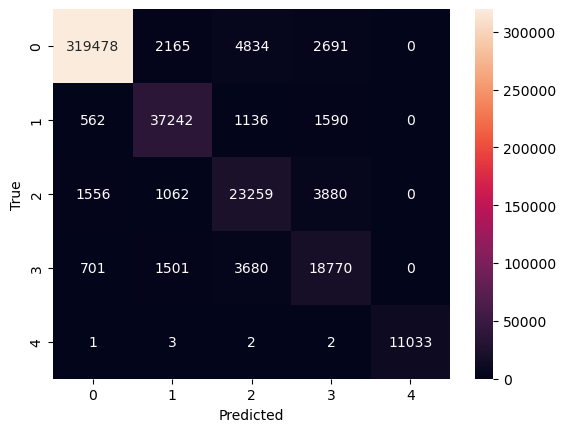

In [42]:

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

We are also seeing 100% accuracy in vulnerability scan. While this fact definetly rises some eyebrows, it's actually readily explainable.

Vulnerability scans are typically more aggressive and generate a higher volume of traffic because they probe multiple points to find vulnerabilities. In other words they are definetly the loudest among all of the recon attacks in the dataaset. Our tree might have just recognized that.

In [69]:
#Display differences in values between vulnerability scans and all other cyberattacks

print((X[y.values==['VulnerabilityScan']].describe()) - (X[(y.values!=['VulnerabilityScan']) & (y.values!=['BenignTraffic'])].describe()))

       flow_duration  header_length       duration          rate  \
count -279796.000000  -2.797960e+05 -279796.000000 -2.797960e+05   
mean      -68.781158   1.869284e+05      -5.596550  7.900409e+00   
std     -1577.971283   4.577915e+05     -26.472725 -1.376040e+04   
min         0.000179   8.000000e+00       3.200000  0.000000e+00   
25%        35.514279   7.609750e+03      16.709999  5.000000e+00   
50%       111.529582   1.332050e+04       1.879997  2.000000e+00   
75%       140.757219   2.768475e+04     -19.532499 -6.000000e+00   
max    -54374.576172   5.869407e+06      -6.929993 -1.336718e+06   

              srate     drate  fin_flag_number  syn_flag_number  \
count -2.797960e+05 -279796.0   -279796.000000   -279796.000000   
mean   7.900409e+00       0.0        -0.000996        -0.163875   
std   -1.376040e+04       0.0        -0.031548        -0.280138   
min    0.000000e+00       0.0         0.000000         0.000000   
25%    5.000000e+00       0.0         0.000000      

This actually confirms our background knowledge, but since it is such an important part, lets summarze the highlights from this analysis.

**Mean Differences**

*flow_duration*: A negative mean suggests that VulnerabilityScan attacks, on average, have shorter flow durations than other cyberattacks. This could be due to the more targeted nature of vulnerability scans.
*header_length*: A positive mean indicates that VulnerabilityScan attacks tend to have larger packet headers, which might be characteristic of the tools used for these scans.
*duration*: Negative values in duration mean that VulnerabilityScan attacks have shorter active durations compared to other attacks, possibly indicating quicker, more efficient scanning processes.
*rate and srate*: Positive values suggest a higher packet transmission rate for VulnerabilityScan attacks, which aligns with the aggressive nature of scanning the network for vulnerabilities.
*syn_flag_number*: The negative mean for SYN flags could imply that VulnerabilityScan attacks use fewer SYN packets, which are typically used to initiate connections, compared to other attacks. This might be because vulnerability scans often involve sending specific types of packets to probe for weaknesses rather than establishing full connections.

**Standard Deviation (std)**
The significant negative std in features like flow_duration, duration, and rate suggests less variability in these features for VulnerabilityScan attacks compared to others, indicating more consistent behavior within VulnerabilityScan attacks.

In short, since this is an automated attack performed on the whole of the network, its we have longer flow durations with packets much heavier. Compared to the other attacks, this one is really noisy.

The differences are quite striking. No wonder our tree managed to detect them!

Going back to our tree's performance, out of roughly 30k test record for 'Recon-OSScan', about 5k are misclassified for 'Benign Traffic'. Other than that, it's clear that decision trees are again a promising family of model. 
However, as decision trees tend to do, it does overfit quite a bit.

Let's continue our search by turning to a more sophisticated model of that family: Random Forest.

From now on we will focus mainly on ensamble techniques.

On a separate notebook I tried several setups for a random forest classifiers, using a GridSearchCV on several hyperparameters. I will show here just the training for the best estimator. I'm keeping the cell outside this notebook as the training time was very long even for specialized cloud services!

In [43]:
# Create a pipeline that resamples the data, then applies scaling, dimensionality reduction, and fits a random forest model
pipeline_test = imbpipeline(steps=[
    ('smote', SMOTE(sampling_strategy=smote_strategy)),
    ('under', RandomUnderSampler(sampling_strategy=undersample_strategy)),
    ('scaler', StandardScaler()),
    
    ('random_forest',RandomForestClassifier(
    n_estimators=300, 
    max_depth=30,  
    min_samples_split=10,  
    min_samples_leaf=10,
    bootstrap=True,
    class_weight='balanced',
    max_features='sqrt',  
    n_jobs=-1, 
    verbose=2
    ))
])

# Fit the pipeline on the training data
pipeline_test.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.5s


building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.3min


building tree 155 of 300
building tree 156 of 300
building tree 157 of 300
building tree 158 of 300
building tree 159 of 300
building tree 160 of 300
building tree 161 of 300
building tree 162 of 300
building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.2min finished


Pipeline(steps=[('smote',
                 SMOTE(sampling_strategy={'Recon-HostDiscovery': 150000,
                                          'Recon-OSScan': 150000,
                                          'Recon-PortScan': 150000,
                                          'VulnerabilityScan': 80000})),
                ('under',
                 RandomUnderSampler(sampling_strategy={'BenignTraffic': 250000})),
                ('scaler', StandardScaler()),
                ('random_forest',
                 RandomForestClassifier(class_weight='balanced', max_depth=30,
                                        min_samples_leaf=10,
                                        min_samples_split=10, n_estimators=300,
                                        n_jobs=-1, verbose=2))])

In [44]:
y_pred = pipeline_test.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    9.1s finished


                     precision    recall  f1-score   support

      BenignTraffic       0.99      0.98      0.99    329168
Recon-HostDiscovery       0.89      0.95      0.92     40530
       Recon-OSScan       0.82      0.79      0.81     29757
     Recon-PortScan       0.74      0.80      0.77     24652
  VulnerabilityScan       1.00      1.00      1.00     11041

           accuracy                           0.96    435148
          macro avg       0.89      0.90      0.90    435148
       weighted avg       0.96      0.96      0.96    435148



In [45]:
y_pred_train = pipeline_test.predict(X_train)

report = classification_report(y_train, y_pred_train)
print(report)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   10.1s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:   21.0s finished


                     precision    recall  f1-score   support

      BenignTraffic       0.99      0.98      0.99    769027
Recon-HostDiscovery       0.91      0.96      0.94     93847
       Recon-OSScan       0.87      0.85      0.86     68502
     Recon-PortScan       0.82      0.87      0.84     57628
  VulnerabilityScan       1.00      1.00      1.00     26341

           accuracy                           0.97   1015345
          macro avg       0.92      0.93      0.93   1015345
       weighted avg       0.97      0.97      0.97   1015345



Now we have improved almost all kpis vs our previous tree. But most importantly, our random forest doesn't overfit nearly as much as our tree! Let's again take a good look at the results.

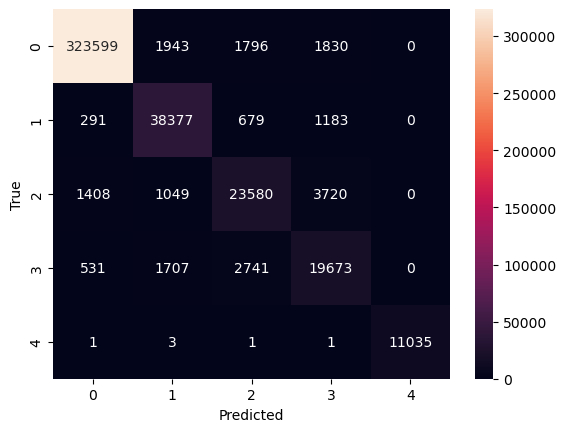

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Again the weakest part of this model is really in the precision of class Port Scan and both precision and recall of Os Scan.

Maybe they will benefit from a diffrent approach. Maybe if we use our adaboost prediction differently, we might be able to specialize the model to the multiclass problem better. 

In the last cases we employed the adaboost prediction feature as a feature. Now I will try another approach and train a the Random Forest only on cyberattacks data and see if it improves!


In [47]:
X_drop.columns

Index(['flow_duration', 'header_length', 'duration', 'rate', 'srate', 'drate',
       'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
       'psh_flag_number', 'ack_flag_number', 'ece_flag_number',
       'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count',
       'rst_count', 'http', 'https', 'dns', 'telnet', 'smtp', 'ssh', 'irc',
       'tcp', 'udp', 'dhcp', 'arp', 'icmp', 'ipv', 'llc', 'tot_sum', 'min',
       'max', 'avg', 'std', 'tot_size', 'iat', 'number', 'magnitue', 'radius',
       'covariance', 'variance', 'weight', 'magnitude',
       'protocol_type_ARGUS (deprecated)', 'protocol_type_BBN-RCC-MON',
       'protocol_type_CBT', 'protocol_type_CHAOS', 'protocol_type_EGP',
       'protocol_type_EMCON', 'protocol_type_GGP', 'protocol_type_HOPOPT',
       'protocol_type_ICMP', 'protocol_type_IGMP', 'protocol_type_IGP',
       'protocol_type_IPv4', 'protocol_type_NVP-II', 'protocol_type_PUP',
       'protocol_type_ST', 'protocol_type_TCP', 'protocol_type_

In [48]:
y_train.head()

1211134          BenignTraffic
445360       VulnerabilityScan
647281     Recon-HostDiscovery
162792           BenignTraffic
947166     Recon-HostDiscovery
Name: label, dtype: object

Now let's create a subset of the dataset only on attacks. Let's do this for all of our training-test components.

In [49]:
y_train_subset = y_train[y_train.values != 'BenignTraffic']
y_test_subset = y_test[y_test.values != 'BenignTraffic']

X_train_subset = X_train[y_train.values != 'BenignTraffic'].drop(['adaboost_binary_pred'], axis=1)
X_test_subset = X_test[y_test.values != 'BenignTraffic'].drop(['adaboost_binary_pred'], axis=1)

X_train_subset.shape[0] == y_train_subset.shape[0]

X_test_subset.shape[0] == y_test_subset.shape[0]

True

In [50]:
y_train_subset.value_counts()

label
Recon-HostDiscovery    93847
Recon-OSScan           68502
Recon-PortScan         57628
VulnerabilityScan      26341
Name: count, dtype: int64

Now I need to modify our resampling strategy. I'll just augment VulnerabilityScan and leave the others as they are.

In [51]:
smote_strategy_new = {'VulnerabilityScan': 50000}

In [52]:
# Create a pipeline that resamples the data, then applies scaling, dimensionality reduction, and fits a random forest model
pipeline_test = imbpipeline(steps=[
    ('smote', SMOTE(sampling_strategy=smote_strategy_new)),

    ('scaler', StandardScaler()),
    
    ('random_forest',RandomForestClassifier(
    n_estimators=300, 
    max_depth=30,  
    min_samples_split=10,
    min_samples_leaf=10,
    bootstrap=True,
    class_weight='balanced',
    max_features='sqrt',  
    n_jobs=-1, 
    verbose=2
    ))
])

# Fit the pipeline on the subset of training data
pipeline_test.fit(X_train_subset, y_train_subset)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 300
building tree 3 of 300
building tree 2 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.5s


building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   45.4s


building tree 155 of 300
building tree 156 of 300
building tree 157 of 300
building tree 158 of 300
building tree 159 of 300
building tree 160 of 300
building tree 161 of 300
building tree 162 of 300
building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.6min finished


Pipeline(steps=[('smote',
                 SMOTE(sampling_strategy={'VulnerabilityScan': 50000})),
                ('scaler', StandardScaler()),
                ('random_forest',
                 RandomForestClassifier(class_weight='balanced', max_depth=30,
                                        min_samples_leaf=10,
                                        min_samples_split=10, n_estimators=300,
                                        n_jobs=-1, verbose=2))])

In [53]:
y_pred_subset = pipeline_test.predict(X_test_subset)

report = classification_report(y_test_subset, y_pred_subset)
print(report)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    2.0s finished


                     precision    recall  f1-score   support

Recon-HostDiscovery       0.94      0.94      0.94     40530
       Recon-OSScan       0.86      0.84      0.85     29757
     Recon-PortScan       0.79      0.81      0.80     24652
  VulnerabilityScan       1.00      1.00      1.00     11041

           accuracy                           0.89    105980
          macro avg       0.90      0.90      0.90    105980
       weighted avg       0.89      0.89      0.89    105980



In [54]:
y_pred_subset_train = pipeline_test.predict(X_train_subset)

report = classification_report(y_train_subset, y_pred_subset_train)
print(report)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    4.8s finished


                     precision    recall  f1-score   support

Recon-HostDiscovery       0.96      0.96      0.96     93847
       Recon-OSScan       0.90      0.88      0.89     68502
     Recon-PortScan       0.86      0.88      0.87     57628
  VulnerabilityScan       1.00      1.00      1.00     26341

           accuracy                           0.92    246318
          macro avg       0.93      0.93      0.93    246318
       weighted avg       0.93      0.92      0.92    246318



It seems that in our reduced dataset the Random Forest got better in almost every class vs the previous version, trained on all the classes. Now I will simply combine the prediction from this adaboost and the Random Forest.

In order to do this I will create a function that returns the prediction of adaboost if it returns benign traffic and otherwise it will return the prediction of Random Forest

In [55]:
def predictor(binary_model, multiclass_model, X):
    binary_pred = binary_model.predict(X)
    multiclass_pred = multiclass_model.predict(X)

    # Use numpy to create a conditional array
    final_pred = np.where(binary_pred == 0, 'BenignTraffic', multiclass_pred)

    return final_pred

In [56]:
pipeline_test.predict(X_test.drop(['adaboost_binary_pred'], axis=1))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    4.7s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:   10.2s finished


array(['Recon-OSScan', 'Recon-OSScan', 'Recon-OSScan', ...,
       'Recon-OSScan', 'Recon-OSScan', 'Recon-OSScan'], dtype=object)

In [57]:
adaboost_loaded.predict(X_test.drop(['adaboost_binary_pred'], axis=1))

array([0, 1, 0, ..., 1, 0, 0], dtype=int64)

In [58]:
final_predictions = predictor(adaboost_loaded, pipeline_test, X_test.drop(['adaboost_binary_pred'], axis=1))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    9.1s finished


In [59]:
print(classification_report(y_test, final_predictions))

                     precision    recall  f1-score   support

      BenignTraffic       0.99      0.98      0.99    329168
Recon-HostDiscovery       0.90      0.94      0.92     40530
       Recon-OSScan       0.81      0.80      0.80     29757
     Recon-PortScan       0.74      0.80      0.77     24652
  VulnerabilityScan       1.00      1.00      1.00     11041

           accuracy                           0.96    435148
          macro avg       0.89      0.90      0.90    435148
       weighted avg       0.96      0.96      0.96    435148



To be fair, our gain was really neglible. This combination of models actually performed worse! While we could try to optimize better our random forest for the subset, I will try to use another ensamble method, XGBoost.

In [60]:
#!pip install xgboost

In order to use it I will have to encode my labels and add as a step of the pipeline.

In [61]:
# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

Now I will need to create a dictionary with the mapping of encoded classes.

In [62]:
# Get the class mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print(label_mapping)

{'BenignTraffic': 0, 'Recon-HostDiscovery': 1, 'Recon-OSScan': 2, 'Recon-PortScan': 3, 'VulnerabilityScan': 4}


I will use the output to adjust SMOTE and RandomUndersampler.

In [63]:

# Adjust Smote and RandomUnderSampler

smote_strategy_enc = {1: 150000, 2: 150000, 3: 150000, 4:80000}
undersample_strategy_enc = {0: 250000}

Now we are ready to launch our usual pipeline with XGBoost and evaluate the perfromance of the model.

In [64]:
pipeline_xgboost = imbpipeline(steps=[
    ('smote', SMOTE(sampling_strategy=smote_strategy_enc)),
    ('under', RandomUnderSampler(sampling_strategy=undersample_strategy_enc)),
    ('scaler', StandardScaler()),
    ('xgboost', XGBClassifier(verbosity=3))
])

# Fit the pipeline on the training data
pipeline_xgboost.fit(X_train, y_train_encoded)

[09:34:12] ======== Monitor (0): HostSketchContainer ========
[09:34:12] AllReduce: 0.018702s, 1 calls @ 18702us

[09:34:12] MakeCuts: 0.019437s, 1 calls @ 19437us

[09:34:12] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[09:34:41] ======== Monitor (0): Learner ========
[09:34:41] Configure: 0.003556s, 1 calls @ 3556us

[09:34:41] EvalOneIter: 0.002313s, 100 calls @ 2313us

[09:34:41] GetGradient: 3.12566s, 100 calls @ 3125660us

[09:34:41] PredictRaw: 0.004101s, 100 calls @ 4101us

[09:34:41] UpdateOneIter: 29.1045s, 100 calls @ 29104517us

[09:34:41] ======== Monitor (0): GBTree ========
[09:34:41] BoostNewTrees: 25.9694s, 100 calls @ 25969400us

[09:34:41] CommitModel: 0.000215s, 100 calls @ 215us

[09:34:41] ======== Monitor (0): HistUpdater ========
[09:34:41] BuildHistogram: 8.96495s, 2500 calls @ 8964947us

[09:34:41] EvaluateSplits: 1.02173s, 3000 calls @ 102

Pipeline(steps=[('smote',
                 SMOTE(sampling_strategy={1: 150000, 2: 150000, 3: 150000,
                                          4: 80000})),
                ('under', RandomUnderSampler(sampling_strategy={0: 250000})),
                ('scaler', StandardScaler()),
                ('xgboost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [65]:
# Example of making predictions
y_pred_encoded = pipeline_xgboost.predict(X_test)
y_pred_xgboost = label_encoder.inverse_transform(y_pred_encoded)

# Example of evaluation
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_xgboost))

[09:34:41] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
                     precision    recall  f1-score   support

      BenignTraffic       0.99      0.98      0.99    329168
Recon-HostDiscovery       0.89      0.95      0.92     40530
       Recon-OSScan       0.82      0.80      0.81     29757
     Recon-PortScan       0.75      0.80      0.78     24652
  VulnerabilityScan       1.00      1.00      1.00     11041

           accuracy                           0.96    435148
          macro avg       0.89      0.91      0.90    435148
       weighted avg       0.96      0.96      0.96    435148



Without tuning hyperparameters we have the best results so far! As this is promising I will check if we can get some other marginal gains by fine tunining it with gridsearchcv.

As our weakest point is precision I will optimize for it.

In [66]:
# Define the pipeline
pipeline_xgboost = imbpipeline(steps=[
    ('smote', SMOTE(sampling_strategy=smote_strategy_enc)),
    ('under', RandomUnderSampler(sampling_strategy=undersample_strategy_enc)),
    ('scaler', StandardScaler()),
    ('xgboost', XGBClassifier(verbosity=2))
])

# Define the parameter grid for XGBoost
param_grid = {
    'xgboost__n_estimators': [100, 200],
    'xgboost__max_depth': [3, 5, 7],
    'xgboost__learning_rate': [0.01, 0.1, 0.2],
    
}


# Define custom scorer for precision
precision_scorer = make_scorer(precision_score, average='macro')

# Create GridSearchCV object
grid_search_xgboost = GridSearchCV(pipeline_xgboost, param_grid, scoring=precision_scorer, cv=3, verbose=3, n_jobs=-1)

# Fit GridSearchCV
grid_search_xgboost.fit(X_train, y_train_encoded)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(sampling_strategy={1: 150000,
                                                                 2: 150000,
                                                                 3: 150000,
                                                                 4: 80000})),
                                       ('under',
                                        RandomUnderSampler(sampling_strategy={0: 250000})),
                                       ('scaler', StandardScaler()),
                                       ('xgboost',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgboost__learning_rate': [0.01, 0.1, 0.2],
                         'xgboost__max_depth': [3, 5, 7],
                         'xgboost__n_estimators': [100, 200]},
             scoring=make_scorer(precision_score, average=macro), verbose=3)

In [67]:
# Print the best hyperparameters found
print("Best parameters found: ", grid_search_xgboost.best_params_)


Best parameters found:  {'xgboost__learning_rate': 0.2, 'xgboost__max_depth': 7, 'xgboost__n_estimators': 200}


Best parameters found:  {'xgboost__learning_rate': 0.2, 'xgboost__max_depth': 7, 'xgboost__n_estimators': 200}

In [68]:
# Get the best estimator
best_model = grid_search_xgboost.best_estimator_

# Print the best estimator
print("Best estimator: ", best_model)


Best estimator:  Pipeline(steps=[('smote',
                 SMOTE(sampling_strategy={1: 150000, 2: 150000, 3: 150000,
                                          4: 80000})),
                ('under', RandomUnderSampler(sampling_strategy={0: 250000})),
                ('scaler', StandardScaler()),
                ('xgboost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               

Let's check the classification properties.

In [69]:
y_pred_encoded = grid_search_xgboost.predict(X_test)
y_pred_xgboost = label_encoder.inverse_transform(y_pred_encoded)



print(classification_report(y_test, y_pred_xgboost))

                     precision    recall  f1-score   support

      BenignTraffic       0.99      0.98      0.99    329168
Recon-HostDiscovery       0.90      0.96      0.93     40530
       Recon-OSScan       0.83      0.80      0.81     29757
     Recon-PortScan       0.76      0.81      0.79     24652
  VulnerabilityScan       1.00      1.00      1.00     11041

           accuracy                           0.96    435148
          macro avg       0.90      0.91      0.90    435148
       weighted avg       0.96      0.96      0.96    435148



Pretty impressive. Let's see how much it overfits.

In [71]:
y_pred_encoded_train = grid_search_xgboost.predict(X_train)
y_pred_xgboost_train = label_encoder.inverse_transform(y_pred_encoded_train)


print(classification_report(y_train, y_pred_xgboost_train))

                     precision    recall  f1-score   support

      BenignTraffic       0.99      0.98      0.99    769027
Recon-HostDiscovery       0.91      0.97      0.94     93847
       Recon-OSScan       0.85      0.83      0.84     68502
     Recon-PortScan       0.80      0.85      0.82     57628
  VulnerabilityScan       1.00      1.00      1.00     26341

           accuracy                           0.96   1015345
          macro avg       0.91      0.93      0.92   1015345
       weighted avg       0.97      0.96      0.97   1015345



Very, very minimal overfitting: our model generalizes well. Before other checks let's save the model.

In [72]:
with open('gridsearch_xgboost.pkl', 'wb') as file:
    pickle.dump(grid_search_xgboost, file)

Now let's inspect it. I want to see which features played a crucial role and how is the feature importance distributed.

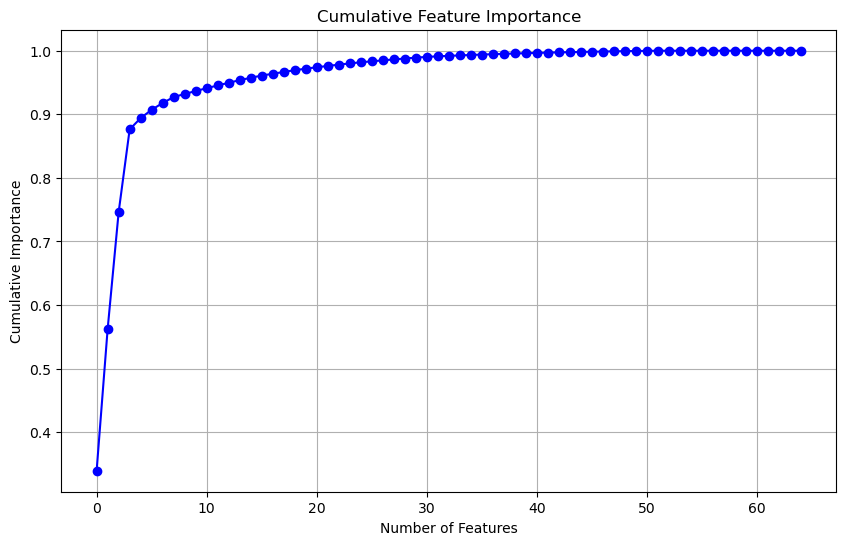

In [72]:


# Load the model from the file
with open('gridsearch_xgboost.pkl', 'rb') as file:
    grid_search_xgboost = pickle.load(file)


# Extract the XGBoost model from the pipeline
xgboost_model = grid_search_xgboost.best_estimator_.named_steps['xgboost']

# Extract feature importances
feature_importances = xgboost_model.feature_importances_

# Sort the feature importances in descending order and calculate the cumulative importance
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_idx]
cumulative_importances = np.cumsum(sorted_importances)

# Plot the cumulative importance
plt.figure(figsize=(10, 6))
plt.plot(range(len(cumulative_importances)), cumulative_importances, marker='o', linestyle='-', color='b')
plt.title('Cumulative Feature Importance')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.grid(True)
plt.show()


Our familiar distribution but with an even sharper rise! Let's see: which of the features did all the heavy lifting?

In [73]:

feature_names = X_test.columns 

# Extract the feature importances and sort them
sorted_indices = np.argsort(xgboost_model.feature_importances_)[::-1]
sorted_features = np.array(feature_names)[sorted_indices]
sorted_importances = xgboost_model.feature_importances_[sorted_indices]

# Display the top 10 most important features
print("Top 10 Features:")
for i in range(10):
    print(f"{i+1}. Feature: {sorted_features[i]}, Importance: {sorted_importances[i]}")


Top 10 Features:
1. Feature: weight, Importance: 0.3394705653190613
2. Feature: iat, Importance: 0.22275781631469727
3. Feature: number, Importance: 0.18389537930488586
4. Feature: adaboost_binary_pred, Importance: 0.1301238089799881
5. Feature: ack_count, Importance: 0.01783524453639984
6. Feature: http, Importance: 0.013045590370893478
7. Feature: syn_flag_number, Importance: 0.010661381296813488
8. Feature: tot_sum, Importance: 0.009321779012680054
9. Feature: protocol_type_BBN-RCC-MON, Importance: 0.0048717535100877285
10. Feature: protocol_type_IGP, Importance: 0.004586947150528431


We can see that the traffic weight (Number of incoming packets × Number of outgoing packets) is the most important metric. Not surprising: attacks tend to have higher number of packets (we have number feature at number 4 providing essentially the same information).
Then we have iat, the time difference between the packets. The more an attacker indulges in recon activities the higher the chances to trigger automated system responses. For this reasons recon activities need to be fast and efficient. Our XG Boost recognized just that.
Our adaboost feature is at number 4, meaning our modelling strategy was indeed succesful.


We see that our XG Boost generalizes very well (I'm genuinely impressed!) and had better scores across the board vs our Random Forest. 
Perhaps most importantly its results are explainable.
At a current stage it's our best model for the multiclassification task.

## Modeling Conclusion:

After a good number of different classifiers that I experimented with, after the rework in preprocessing and feature engineering we have reached a satisfactory level of confidence in predicting the occurence of an attack and the attack surface.

The occurence of recon attack was predicted with Adaboost based on optimezed tree classifier with Recall Macro Average at 95%+. 

We also found success in identifying the surface area (or the kind of cyberattack) with a 91%+  Macro Recall Score. We achieved this through an optimized version of adaboost and through the usage of the Adaboost predictions. This ensable model really did a great job although Port and OS scan had sensibly lower scores.

Both of the models seems to generalize quite well as overfitting is minimal.

## Next steps

The natural next step would be to employ deep learning to the multiclass problem in isolation and as a component in techniques like stacking.
The overall system would greatly benefit from the introduction of different models other than tree based methods as they could introduce a little bit of diversity in the prediction that could potentially benefit a meta-learner.

In general threshold based models have been really pushed to their limits in this work and any further refinement like changing the number of estimators would likely lead to overfitting. There is a need for a different 

But that will be for the next sprint!


## Inference setup

I will now proceed to setup the data and the models for our two-stage inference process. To do so I will only need to remove the adaboost preiction from our X_test data.
We have already saved our models, now we can save our data.

As a reminder I will outline here the inference process:

- Load samples from X_test
- Predict with our adaboost model
- Store the results as a column
- Predict with our XG Boost

A note, I deliberately didn't apply feature selection steps that could make inference process less intuitive. The plan is in fact to apply another modelling layer to better predict device-based attacks.


In [35]:
X_test.columns

Index(['flow_duration', 'header_length', 'duration', 'rate', 'srate', 'drate',
       'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
       'psh_flag_number', 'ack_flag_number', 'ece_flag_number',
       'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count',
       'rst_count', 'http', 'https', 'dns', 'telnet', 'smtp', 'ssh', 'irc',
       'tcp', 'udp', 'dhcp', 'arp', 'icmp', 'ipv', 'llc', 'tot_sum', 'min',
       'max', 'avg', 'std', 'tot_size', 'iat', 'number', 'magnitue', 'radius',
       'covariance', 'variance', 'weight', 'magnitude',
       'protocol_type_ARGUS (deprecated)', 'protocol_type_BBN-RCC-MON',
       'protocol_type_CBT', 'protocol_type_CHAOS', 'protocol_type_EGP',
       'protocol_type_EMCON', 'protocol_type_GGP', 'protocol_type_HOPOPT',
       'protocol_type_ICMP', 'protocol_type_IGMP', 'protocol_type_IGP',
       'protocol_type_IPv4', 'protocol_type_NVP-II', 'protocol_type_PUP',
       'protocol_type_ST', 'protocol_type_TCP', 'protocol_type_

In [38]:
X_test.drop(['adaboost_binary_pred'], axis=1).to_csv('X_test.csv',index=False)